# Netfilx Movies and TV Shows EDA and analysis

In [25]:
import os
os.chdir(r"C:\Users\admin\Desktop\Data Analytics\Netflix data analysis")

# Importing Library and Data

In [26]:
#Data Analysis
import pandas as pd
from pandas import Series
import numpy as np
import re
import country_converter as coco

#Data Visualization
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

#Data Visualization Setting
%matplotlib inline
pd.set_option('display.max_columns',None)
plt.style.use('seaborn-dark-palette')
plt.style.use('dark_background')

In [27]:
df=pd.read_csv(r"C:\Users\admin\Desktop\Data Analytics\Netflix data analysis\Netflix Data Analysis.csv")
df.drop(["id", "description", "imdb_id"], axis=1, inplace=True)

In [28]:
df.head()

,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,Five Came Back: The Reference Films,SHOW,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,0.600,NaN
1,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179
2,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600


In [29]:
print("Shape of the dateset:", df.shape)

Shape of the dateset: (5850, 12)


Our dataset has 12 columns and 5850 rows.

# Basic Data Cleaning

Text(0.5, 1.0, 'Missing Values Matrix')

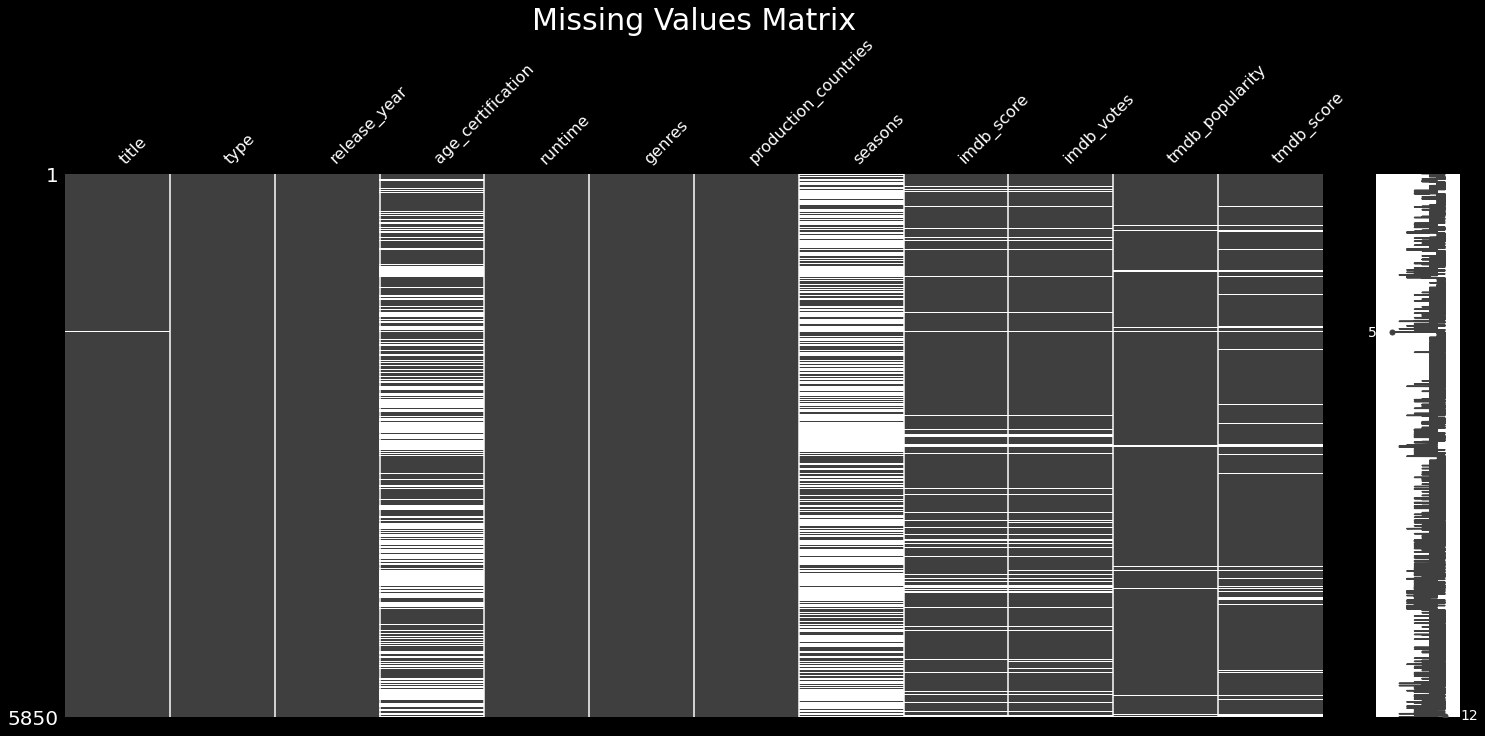

In [30]:
msno.matrix(df)
plt.title("Missing Values Matrix",fontsize=30)

We can see that most of our missing values are from age_certification and seasons columns.

In [31]:
df=df[~df['title'].isnull()]

The NaN in title is not recognizable, and there is only one item without a title, so I decide to directly remove it.

In [32]:
print(df["age_certification"].unique())
df["age_certification"].fillna("Not Rated",inplace=True)

['TV-MA' 'R' 'PG' nan 'TV-14' 'PG-13' 'TV-PG' 'TV-Y' 'TV-G' 'TV-Y7' 'G'
 'NC-17']


I checked the unique catagories in age_certification column and matched them with Netfilx age rating list, I found that the dataset include all of the age rating, and the missing values are those movies or shows that haven't been rated on the website that the data came from.

In [33]:
df[df["seasons"].isnull()]["type"].value_counts()

MOVIE    3743
Name: type, dtype: int64

In [34]:
df["type"].value_counts()

MOVIE    3743
SHOW     2106
Name: type, dtype: int64

I found that all of the missing values in seasons columns are actually movies, it is reasonable that movies don't have any season. Instead of keep them as NaN or drop all of them, I decided to fill them with 0.

In [35]:
df["seasons"].fillna(0,inplace=True)

In [36]:
four_col = df[["imdb_score","imdb_votes","tmdb_popularity","tmdb_score"]]
df[["imdb_score","imdb_votes","tmdb_popularity","tmdb_score"]] = four_col.apply(lambda x : x.fillna(np.mean(x)))

Filling the NaN values from above columns using their own average values.

In [37]:
df.isnull().sum()

title                   0
type                    0
release_year            0
age_certification       0
runtime                 0
genres                  0
production_countries    0
seasons                 0
imdb_score              0
imdb_votes              0
tmdb_popularity         0
tmdb_score              0
dtype: int64

There is not missing value in the dataset now.

# Type

What is the distribution of type

In [38]:
type_count = df["type"].value_counts()

type_fig = px.pie(values=type_count.values,names=type_count.index,template="plotly_dark",title="Type distribution")
type_fig.update_traces(textinfo='label+percent+value')
type_fig.update_layout(font = dict(size= 15, family="Franklin Gothic"))
type_fig.show()

In this dataset, 36% data is Show and 64% data is Movie

# Age certification

What are the top 10 frequent age certification?

In [39]:
age_count = df["age_certification"].value_counts()[:10]
age_fig = px.bar(y=age_count.values,x=age_count.index,text=age_count.values,title="Top 10 Age certification count",color=age_count.index,template="plotly_dark")
age_fig.update_layout(xaxis_title="Age certification",yaxis_title="Count")
age_fig.update_layout(font = dict(size= 15, family="Franklin Gothic"))
age_fig.show()

The most frequent age certification is Not Rated, which has 2618 results, the second one is TV-MA, which is the TV Parental Guidelines signifies content for mature audiences, has 883 results.

# Genres

What are the top 10 frequent genre?

In [40]:
df["genres"]

0                                 ['documentation']
1                                ['drama', 'crime']
2       ['drama', 'action', 'thriller', 'european']
3                   ['fantasy', 'action', 'comedy']
4                                 ['war', 'action']
                           ...                     
5845                           ['romance', 'drama']
5846                                      ['drama']
5847                                     ['comedy']
5848                                             []
5849              ['family', 'animation', 'comedy']
Name: genres, Length: 5849, dtype: object

We can see there are some shows or movies have more than one genre, counting each genre combination as a new catagory might not be a good decision, so I would like to split them into single genres and count them.

In [41]:
genreslist = list()
df.genres.str.findall(r"'(\w+?)'").map(lambda x: genreslist.extend(x))
top_10_genres = pd.Series(genreslist).value_counts()[:10]

In [42]:
genres_fig = px.bar(y=top_10_genres.values,x=top_10_genres.index,text=top_10_genres,title="Top 10 Genres",color=top_10_genres.index,template="plotly_dark")
genres_fig.update_layout(xaxis_title="Genre",yaxis_title="Count")
genres_fig.update_layout(font = dict(size= 15, family="Franklin Gothic"))
genres_fig.show()

# Production Countries

What is the count of each country?

In [43]:
country_list = list()
df.production_countries.str.findall(r"'(\w+?)'").map(lambda x: country_list.extend(x))

country_list = pd.Series(country_list).replace("Lebanon","LB")
country_list = country_list.value_counts()
country_list = country_list.drop(index=["SU","XX"])

In [44]:
country_list.index = coco.convert(names=country_list.index, to="ISO3") 

fig = px.choropleth(locations=country_list.index,
                    color=country_list.values,
                    template='plotly_dark',
                    title = 'Production Countries Distribution Map')
fig.update_layout(font = dict(size= 15, family="Franklin Gothic"))
fig.show()

As the world map shows above, it obvious to find that the United States has the darkest color, which means, for this dataset, the United States produces the most of shows and movies.

# release_year

In [46]:
year_df = df.groupby("type")["release_year"].apply(list)
Year_label = ["Type: Movie","Type: Show"]
color = ["yellow","red"]

year_fig = ff.create_distplot(year_df,Year_label,colors=color,show_hist=False)
year_fig.layout.template = "plotly_dark"
year_fig.update_layout(title="Runtime Distribution",font=dict(size = 13,family="Franklin Gothic"))
year_fig.update_layout(xaxis_title="Runtime",yaxis_title="Density")
year_fig.show()

Most of the shows in the dataset relased around the second half of 2019, and most of the movies released around the first half of 2019.

# Seasons : Show

In [47]:
seasons_fig = px.box(y=df[df["type"]=="SHOW"]["seasons"],template= 'plotly_dark', title = 'Shows Season Analysis(Boxplot)')
seasons_fig.update_layout(font = dict(size= 15, family="Franklin Gothic"))

In [55]:
df[df['seasons']==42]

,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,action,animation,comedy,crime,documentation,drama,european,family,fantasy,history,horror,music,reality,romance,scifi,sport,thriller,war,western
91,Survivor,SHOW,2000,TV-PG,48,['reality'],['US'],42.0,7.4,24687.0,54.19,7.4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


I would like to analyze the season for shows because movies don't have actual season value, even though I assigned them value of 0.

The boxplot shows that most of shows only have 1 season, but there is one show have 42 seasons, which is a show called Survivor.


# Runtime

In [48]:
runtime_df = df.groupby("type")["runtime"].apply(list)

runtime_label = ["Type: Movie","Type: Show"]
color = ["yellow","red"]

runtime_fig = ff.create_distplot(runtime_df,runtime_label,colors=color,show_hist=False)
runtime_fig.layout.template = "plotly_dark"
runtime_fig.update_layout(font = dict(size = 15,family="Franklin Gothic"))
runtime_fig.update_layout(title="Runtime Distribution" ,xaxis_title="Runtime",yaxis_title="Density")
runtime_fig.show()

For movies, the most common runtime is around 96 mins. For shows, the most common runtime is around 45 mins.

# Age Certification Analysis

What is the average runtime of each type by age certification?

In [49]:
mean_movie_runtime = df.groupby(["type","age_certification"])["runtime"].agg(np.mean).round(0).sort_values(ascending=False)

In [50]:
runtime_age_fig = go.Figure(data=
[go.Bar(name="Movie",x=mean_movie_runtime["MOVIE"].index,y=mean_movie_runtime["MOVIE"].values,text=mean_movie_runtime["MOVIE"].values),
go.Bar(name="Show",x=mean_movie_runtime["SHOW"].index,y=mean_movie_runtime["SHOW"].values,text=mean_movie_runtime["SHOW"].values)])
runtime_age_fig.update_layout(title="Average runtime by type and age certification",xaxis_tickangle=45,xaxis_title="Age certification",yaxis_title="Average Runtime")
runtime_age_fig.layout.template = "plotly_dark"
runtime_age_fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
runtime_age_fig.show()

1. For movies, the age certification of PG-13 has the highest average runtime of 107 mins, the age certification of G has the lowest average runtime of 89 mins.

2. For shows, the age certification of TV-MA has the highest average runtime of 43 mins, the age certification of TV-Y has the lowest average runtime of 17 mins.

# Genre Analysis

What is the most and least frequency genres of each type?

In [52]:
from functools import reduce
genresdummylist = df.genres.str.extractall(r"'(\w+)'").unstack()
dummylist = list()
for i in genresdummylist.columns:
    dummylist.append(pd.get_dummies(genresdummylist[i]))

dummy = reduce(lambda x, y: x.add(y, fill_value=0), dummylist).astype(int)
df = pd.merge(df, dummy, left_index=True, right_index=True)

In [53]:
type_genres_count = df[list(dummy.columns)].groupby(df['type']).sum()
type_genres_count

,action,animation,comedy,crime,documentation,drama,european,family,fantasy,history,horror,music,reality,romance,scifi,sport,thriller,war,western
type,,,,,,,,,,,,,,,,,,,
MOVIE,718,282,1571,545,611,1876,344,351,315,145,261,191,9,698,204,113,825,103,28
SHOW,439,423,754,391,341,1092,99,331,315,109,117,71,225,273,385,57,403,60,13


In [54]:
type_genres_fig = go.Figure(data=
[go.Bar(name="Movie",x=type_genres_count.loc["MOVIE"].index,y=type_genres_count.loc["MOVIE"].values,text=type_genres_count.loc["MOVIE"].values),
go.Bar(name="Show",x=type_genres_count.loc["SHOW"].index,y=type_genres_count.loc["SHOW"].values,text=type_genres_count.loc["SHOW"].values)])
type_genres_fig.update_layout(title="Frequency of genres by type",xaxis_tickangle=45,xaxis_title="Genres",yaxis_title="Frequency")
type_genres_fig.layout.template = "plotly_dark"
type_genres_fig.update_layout(font=dict(size = 15,family="Franklin Gothic"))
type_genres_fig.update_layout(barmode="stack",xaxis_categoryorder="total descending")
type_genres_fig.show()

The most frequency of genre for both movie and show is drama, there are 1092 shows and 1876 movies include the genre of drama. The least frequency one is western, only 13 and 28 movies include the genre of western.

# The End